# Trans-dimensional Surface Wave Inversion

<!-- Please leave the cell below as it is -->

{{ badge }}

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

<!-- TODO - background introduction for this problem. -->

In this notebook, we use a trans-dimensional McMC sampler to run the 

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi git+https://github.com/miili/pysurf96.git

In [2]:
from typing import Union
from numbers import Number
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from pysurf96 import surf96
import bayesbay as bb
import cofi

np.random.seed(42)

## 1. Preparation

Before running inversion, we firstly define some constants, the forward function,
and generate some noisy synthetic data.

In this example, we use `pysurf96` to perform the forward operation.

In [3]:
VP_VS = 1.77
RAYLEIGH_STD = 0.02
RF_STD = 0.03
LAYERS_MIN = 3
LAYERS_MAX = 15
LAYERS_INIT_RANGE = 0.3
VS_PERTURB_STD = 0.15
VS_UNIFORM_MIN = 2.7
VS_UNIFORM_MAX = 5
VORONOI_PERTURB_STD = 8
VORONOI_POS_MIN = 0
VORONOI_POS_MAX = 150
N_CHAINS = 2

In [4]:
def forward_sw(model, periods, wave="rayleigh", mode=1):
    k = int(len(model) / 2)
    sites = model[:k]
    vs = model[k:]
    depths = (sites[:-1] + sites[1:]) / 2
    thickness = np.hstack((depths[0], depths[1:] - depths[:-1], 0))
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    return surf96(
        thickness,
        vp,
        vs,
        rho,
        periods,
        wave=wave,
        mode=mode,
        velocity="phase",
        flat_earth=False,
    )

In [5]:
true_thickness = np.array([10, 10, 15, 20, 20, 20, 20, 20, 0])
true_voronoi_positions = np.array([5, 15, 25, 45, 65, 85, 105, 125, 145])
true_vs = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
true_model = np.hstack((true_thickness, true_vs))

In [6]:
periods1 = np.linspace(4, 80, 20)
rayleigh1 = forward_sw(true_model, periods1, "rayleigh", 1)
rayleigh1_dobs = rayleigh1 + np.random.normal(0, RAYLEIGH_STD, rayleigh1.size)

## 2. Running the sampler

### 2.1 Define the problem

In [7]:
def log_likelihood(model):
    rayleigh_dpred = forward_sw(model, periods1)
    rayleigh_residual = rayleigh1_dobs - rayleigh_dpred
    rayleigh_loglike = -0.5 * np.sum(
        (rayleigh_residual / RAYLEIGH_STD) ** 2
        + math.log(2 * np.pi * RAYLEIGH_STD**2)
    )
    return rayleigh_loglike

In [8]:
sw_problem = cofi.BaseProblem()
sw_problem.set_log_likelihood(log_likelihood)

Review what information is included in the `BaseProblem` object:

In [9]:
sw_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
---------------------------------------------------------------------
List of functions/properties set by you:
['log_likelihood']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
-- none --
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_prior', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'initial_model', 'model_shape', 'blobs_dtype', 'bounds', 'constraints']


### 2.2 Define the inversion options

In [10]:
def log_prior(model):
    k = len(model) // 2
    # p(k) and p(c|k) are to be cancelled out in acceptance criteria
    # p(v|k) prior on param value given #layers
    log_p_v_k = -k * math.log(VS_UNIFORM_MAX - VS_UNIFORM_MIN)
    return log_p_v_k

#### Implement perturbation functions

In [11]:
def perturbation_vs(model):
    k = int(len(model) / 2)
    sites = model[:k]
    vs = model[k:]
    # randomly choose a Voronoi site to perturb the value
    isite = random.randint(0, k - 1)
    # randomly perturb the value
    while True:
        random_deviate = random.normalvariate(0, VS_PERTURB_STD)
        new_value = vs[isite] + random_deviate
        if new_value > VS_UNIFORM_MAX or new_value < VS_UNIFORM_MIN:
            continue
        break
    # integrate into a new model variable
    new_vs = vs.copy()
    new_vs[isite] = new_value
    new_model = np.hstack((sites, new_vs))
    log_prob_ratio = 0
    return new_model, log_prob_ratio


def perturbation_voronoi_site(model):
    k = int(len(model) / 2)
    sites = model[:k]
    vs = model[k:]
    # randomly choose a Voronoi site to perturb the position
    isite = random.randint(0, k - 1)
    old_site = sites[isite]
    # randomly perturb the position
    while True:
        random_deviate = random.normalvariate(0, VORONOI_PERTURB_STD)
        new_site = old_site + random_deviate
        if (
            new_site < VORONOI_POS_MIN
            or new_site > VORONOI_POS_MAX
            or np.any(np.abs(new_site - sites) < 1e-2)
        ):
            continue
        break
    # integrate into a new model variable
    new_sites = sites.copy()
    new_sites[isite] = new_site
    isort = np.argsort(new_sites)
    new_sites = new_sites[isort]
    new_vs = vs[isort]
    new_model = np.hstack((new_sites, new_vs))
    log_prob_ratio = 0
    return new_model, log_prob_ratio


def perturbation_birth(model):
    k = int(len(model) / 2)
    sites = model[:k]
    vs = model[k:]
    if k == LAYERS_MAX:
        raise ValueError("Maximum layers reached")
    # randomly choose a new Voronoi site position
    while True:
        new_site = random.uniform(VORONOI_POS_MIN, VORONOI_POS_MAX)
        # abort if it's too close to existing positions
        if np.any(np.abs(new_site - sites) < 1e-2):
            continue
        break
    # randomly sample the value for the new site
    new_vs_isite = random.uniform(VS_UNIFORM_MIN, VS_UNIFORM_MAX)
    # integrate into a new model variable and sort properly
    new_sites = np.append(sites, new_site)
    new_vs = np.append(vs, new_vs_isite)
    isort = np.argsort(new_sites)
    new_sites = new_sites[isort]
    new_vs = new_vs[isort]
    new_model = np.hstack((new_sites, new_vs))
    # calculate partial acceptance probability
    log_prob_ratio = 0
    return new_model, log_prob_ratio


def perturbation_death(model):
    k = int(len(model) / 2)
    sites = model[:k]
    vs = model[k:]
    if k == LAYERS_MIN:
        raise ValueError("Minimum layers reached")
    # randomly choose an existing Voronoi site to remove
    isite = random.randint(0, k - 1)
    # integrate into a new model variable
    new_sites = np.delete(sites, isite)
    new_vs = np.delete(vs, isite)
    new_model = np.hstack((new_sites, new_vs))
    # calculate partial acceptance probability
    log_prob_ratio = 0
    return new_model, log_prob_ratio

#### Initialize the walkers

In [12]:
init_max = int((LAYERS_MAX - LAYERS_MIN) * LAYERS_INIT_RANGE + LAYERS_MIN)
walkers_start = []
for i in range(N_CHAINS):
    n_sites = random.randint(LAYERS_MIN, init_max)
    sites = np.sort(np.random.uniform(VORONOI_POS_MIN, VORONOI_POS_MAX, n_sites))
    vs = np.sort(np.random.uniform(VS_UNIFORM_MIN, VS_UNIFORM_MAX, n_sites))
    model = np.hstack((sites, vs))
    walkers_start.append(model)

#### Define the inversion options

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("bayesbay")
my_options.set_params(
    perturbation_funcs = [
        perturbation_vs,
        perturbation_voronoi_site,
        perturbation_birth,
        perturbation_death,
    ],
    walkers_starting_models = walkers_start, 
    n_chains = N_CHAINS, 
    n_cpus = N_CHAINS, 
    n_iterations=10_000,
    burnin_iterations=4_000,
    save_every=100,
    print_every=500,
    verbose=False
)

Review what's been defined for the inversion we are about to run:

In [14]:
my_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._bayes_bay.BayesBay'>` - ['Wrapper for BayesBay, a trans-dimensional reversible jump Bayesian samplingframework']
References: ['https://bayes-bay.readthedocs.io/en/latest/api/generated/bayesbay.BaseBayesianInversion.html#bayesbay.BaseBayesianInversion']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
perturbation_funcs = [<function perturbation_vs at 0x7fe192d87040>, <function perturbation_voronoi_site at 0x7fe192d871f0>, <function perturbation_birth at 0x7fe192d87280>, <function perturbation_death at 0x7fe192d87310>]
walkers_starting_models = [array([  6.96756191,  29.95106732,  68.41049763,  77.13516576,
        88.86218533, 117.77639421,   2.84961866,   3.09220548,
         4.09735316,   4.5593139 ,   4.88243674,   4.92095368]), arra

### 2.3 Start an inversion

In [15]:
sw_inversion = cofi.Inversion(sw_problem, my_options)
inv_result = sw_inversion.run()

### 2.4 Visualise results

<Axes: xlabel='Parameter values', ylabel='Depth'>

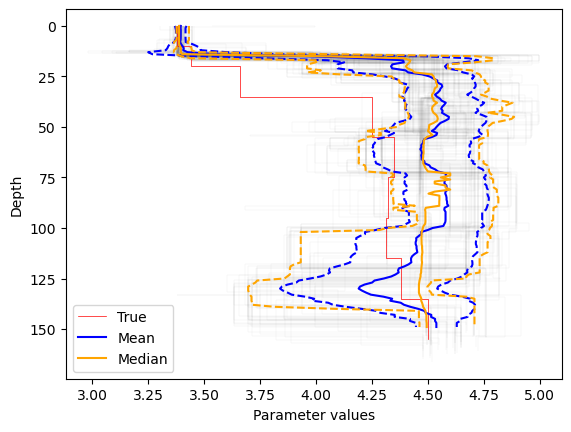

In [16]:
def _calc_thickness(model: np.ndarray):
    k = len(model) // 2
    sites = model[:k]
    depths = (sites[:-1] + sites[1:]) / 2
    thickness = np.hstack((depths[0], depths[1:] - depths[:-1], 0))
    return thickness

def _get_vs(model: np.ndarray):
    k = int(len(model) / 2)
    return model[k:]

saved_models = inv_result.models
interp_depths = np.arange(VORONOI_POS_MAX, dtype=float)
all_thicknesses = [_calc_thickness(m) for m in saved_models]
all_vs = [_get_vs(m) for m in saved_models]

# plot samples, true model and statistics (mean, median, quantiles, etc.)
ax = bb.discretization.Voronoi1D.plot_depth_profiles(
    all_thicknesses, all_vs, linewidth=0.1, color="k"
)
bb.discretization.Voronoi1D.plot_depth_profiles(
    [true_thickness], [true_vs], alpha=1, ax=ax, color="r", label="True"
)
bb.discretization.Voronoi1D.plot_depth_profiles_statistics(
    all_thicknesses, all_vs, interp_depths, ax=ax
)

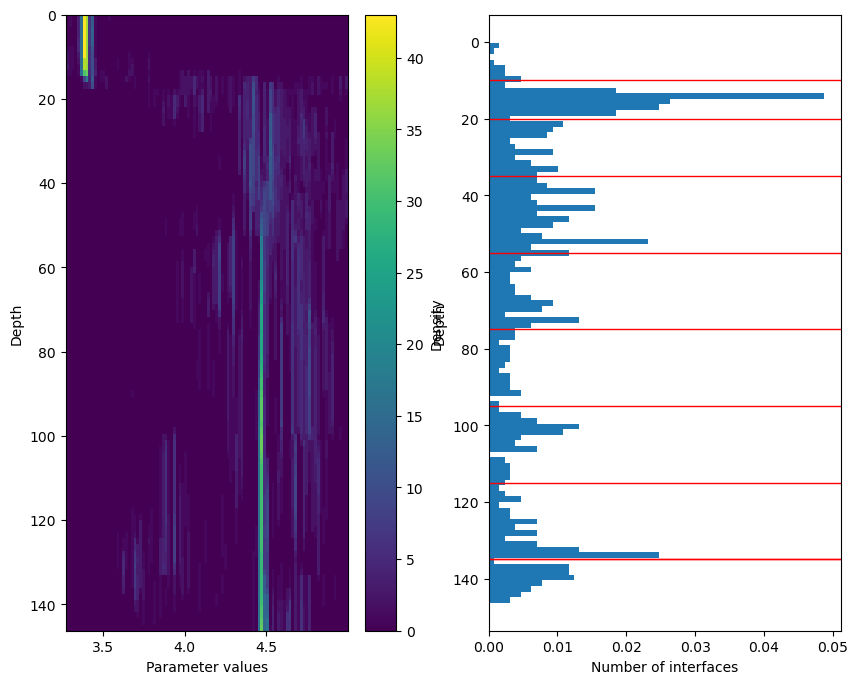

In [17]:
# plot depths and velocities density profile
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
bb.discretization.Voronoi1D.plot_depth_profiles_density(
    all_thicknesses, all_vs, ax=axes[0]
)
bb.discretization.Voronoi1D.plot_interface_hist(
    all_thicknesses, ax=axes[1]
)
for d in np.cumsum(true_thickness):
    axes[1].axhline(d, color="red", linewidth=1)

## 3. Running the sampler with BayesBay utilities

In this section, we demonstrate how we can use BayesBay as a helper to simplify
the inversion preparation process. 

Instead of doing the following on our own:
- defining the perturbation functions; 
- initializing the walkers on our own

We will:
- configure parameters
- configure parameterization
- feed data targets into the helpers

So that BayesBay generates perturbation functions and initializes walkers for us.

### 3.1 Preparation

#### Update forward function to take in `bayesbay.State` as input

In [18]:
def _calc_thickness(sites: np.ndarray):
    depths = (sites[:-1] + sites[1:]) / 2
    thickness = np.hstack((depths[0], depths[1:] - depths[:-1], 0))
    return thickness

def _get_thickness(model: bb.State):
    sites = model["voronoi"]["discretization"]
    if model.has_cache("thickness"):
        thickness = model.load_cache("thickness")
    else:
        thickness = _calc_thickness(sites)
        model.store_cache("thickness", thickness)
    return thickness

def forward_sw(model, periods, wave="rayleigh", mode=1):
    vs = model["voronoi"]["vs"]
    thickness = _get_thickness(model)
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    return surf96(
        thickness,
        vp,
        vs,
        rho,
        periods,
        wave=wave,
        mode=mode,
        velocity="phase",
        flat_earth=False,
    )

#### Configure targets and forward functions

In [19]:
targets = [
    bb.Target("rayleigh1", rayleigh1_dobs, covariance_mat_inv=1 / RAYLEIGH_STD**2),
]

fwd_functions = [
    (forward_sw, [periods1, "rayleigh", 1]),
]

#### Configure parameters

In [20]:
param_vs = bb.parameters.UniformParameter(
    name="vs",
    vmin=VS_UNIFORM_MIN,
    vmax=VS_UNIFORM_MAX,
    perturb_std=VS_PERTURB_STD,
)


def param_vs_initialize(
    param: bb.parameters.Parameter, 
    positions: Union[np.ndarray, Number]
) -> Union[np.ndarray, Number]: 
    vmin, vmax = param.get_vmin_vmax(positions)
    if isinstance(positions, (float, int)):
        return random.uniform(vmin, vmax)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    for i in range (len(sorted_vals)):
        val = sorted_vals[i]
        vmin_i = vmin if np.isscalar(vmin) else vmin[i]
        vmax_i = vmax if np.isscalar(vmax) else vmax[i]
        if val < vmin_i or val > vmax_i:
            if val > vmax_i: sorted_vals[i] = vmax_i
            if val < vmin_i: sorted_vals[i] = vmin_i
    return sorted_vals


param_vs.set_custom_initialize(param_vs_initialize)
free_parameters = [param_vs]

#### Configure parameterization

In [21]:
parameterization = bb.parameterization.Parameterization(
    bb.discretization.Voronoi1D(
        name="voronoi", 
        vmin=VORONOI_POS_MIN, 
        vmax=VORONOI_POS_MAX, 
        perturb_std=VORONOI_PERTURB_STD, 
        n_dimensions=None, 
        n_dimensions_min=LAYERS_MIN, 
        n_dimensions_max=LAYERS_MAX, 
        n_dimensions_init_range=LAYERS_INIT_RANGE, 
        parameters=free_parameters,
        birth_from="prior", 
    )
)

#### Initialize walkers

In [22]:
walkers_start = []
for i in range(N_CHAINS):
    walkers_start.append(parameterization.initialize())

### 3.2 Define the inversion options

In [23]:
my_options = cofi.InversionOptions()
my_options.set_tool("bayesbay")
my_options.set_params(
    log_like_ratio_func=bb.LogLikelihood(targets, fwd_functions), 
    perturbation_funcs = parameterization.perturbation_functions, 
    walkers_starting_models=walkers_start, 
    n_chains=N_CHAINS,
    n_cpus=N_CHAINS,
    n_iterations=10_000,
    burnin_iterations=4_000,
    save_every=100,
    print_every=500,
    verbose=False,
)

### 3.3 Start an inversion

In [24]:
sw_inversion = cofi.Inversion(sw_problem, my_options)
inv_result = sw_inversion.run()

### 3.4 Visualise results

In [25]:
saved_models = inv_result.models
interp_depths = np.arange(VORONOI_POS_MAX, dtype=float)
all_thicknesses = [_calc_thickness(m) for m in saved_models["voronoi.discretization"]]

<Axes: xlabel='Parameter values', ylabel='Depth'>

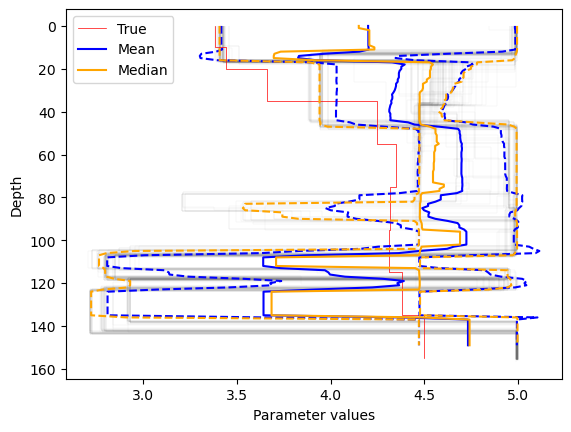

In [26]:
# plot samples, true model and statistics (mean, median, quantiles, etc.)
ax = bb.discretization.Voronoi1D.plot_depth_profiles(
    all_thicknesses, saved_models["vs"], linewidth=0.1, color="k"
)
bb.discretization.Voronoi1D.plot_depth_profiles(
    [true_thickness], [true_vs], alpha=1, ax=ax, color="r", label="True"
)
bb.discretization.Voronoi1D.plot_depth_profiles_statistics(
    all_thicknesses, saved_models["vs"], interp_depths, ax=ax
)

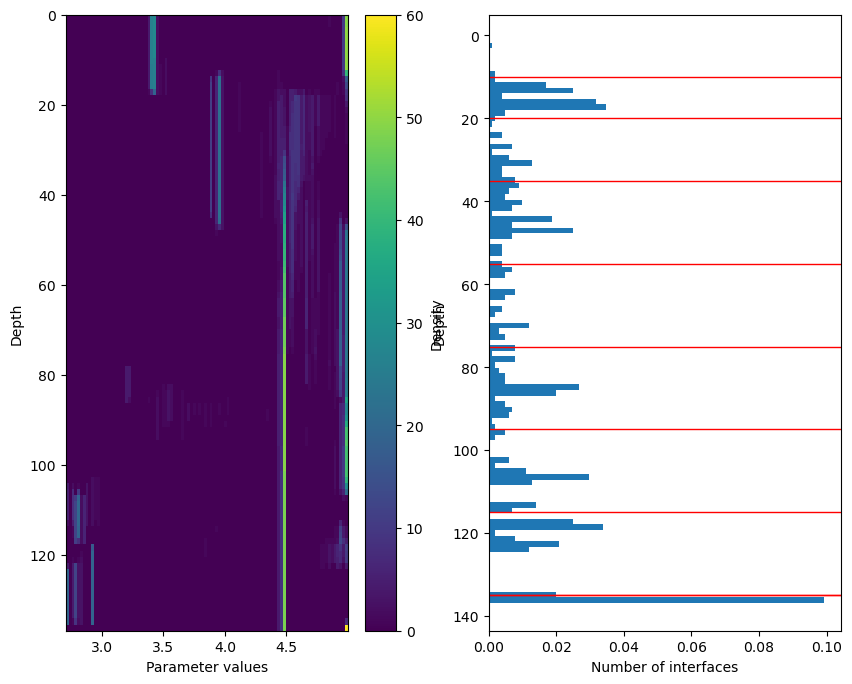

In [27]:
# plot depths and velocities density profile
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
bb.discretization.Voronoi1D.plot_depth_profiles_density(
    all_thicknesses, saved_models["vs"], ax=axes[0]
)
bb.discretization.Voronoi1D.plot_interface_hist(
    all_thicknesses, ax=axes[1]
)
for d in np.cumsum(true_thickness):
    axes[1].axhline(d, color="red", linewidth=1)

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [28]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "bayesbay"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.5
numpy 1.23.5
scipy 1.10.1
matplotlib 3.7.1
bayesbay 0.1.3
